In [1]:
%load_ext autoreload
%autoreload 2

import os
import io
import time
import requests
import zipfile
import typing

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from by_interview.definitions import ROOT_DIR

In [2]:
folder_path_data = os.path.join(ROOT_DIR, 'data')
os.makedirs(folder_path_data, exist_ok=True)

file_names_data = [f for f in os.listdir(folder_path_data)
                   if os.path.isfile(os.path.join(folder_path_data, f))
                   and f.endswith('.csv')]

print('Found these data files:', file_names_data)

Found these data files: ['day.csv', 'hour.csv']


### download data if not done already

In [3]:
if len(file_names_data) == 0:
    # no csv files in the data folder
    # download the original zip file
    
    print('Downloading data...')
    t0 = time.time()
    
    url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
    r = requests.get(url_data)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(folder_path_data)
    
    print(f'Download finished in {time.time() - t0:.2f}s')

### load data

In [4]:
mappings = {
    'season':{
        '1':'winter',
        '2':'spring',
        '3':'summer',
        '4':'fall'
    },
    'weathersit':{
        '1': 'Clear',
        '2': 'Mist_Cloudy',
        '3': 'Light Snow-Rain',
        '4': 'Heavy Rain'
    }
}


def preprocess_data(df:pd.DataFrame, mappings:typing):
    
    for col, mapping in mappings.items():
        df.loc[:, col] = df.loc[:, col].replace(mapping).astype('category')
    
    return df

In [5]:
csv_kwargs = {
    'parse_dates':['dteday'],
    'index_col':'instant',
    'dtype':{
        'yr':'category',
        'mnth':'category',
        'season':'category',
        'holiday':'category',
        'weekday':'category',
        'workingday':'category',
        'weathersit':'category'
    }
}

In [6]:
file_path = os.path.join(folder_path_data, 'day.csv')
df_d = pd.read_csv(file_path, **csv_kwargs)
df_d = preprocess_data(df_d, mappings)
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      731 non-null    datetime64[ns]
 1   season      731 non-null    category      
 2   yr          731 non-null    category      
 3   mnth        731 non-null    category      
 4   holiday     731 non-null    category      
 5   weekday     731 non-null    category      
 6   workingday  731 non-null    category      
 7   weathersit  731 non-null    category      
 8   temp        731 non-null    float64       
 9   atemp       731 non-null    float64       
 10  hum         731 non-null    float64       
 11  windspeed   731 non-null    float64       
 12  casual      731 non-null    int64         
 13  registered  731 non-null    int64         
 14  cnt         731 non-null    int64         
dtypes: category(7), datetime64[ns](1), float64(4), int64(3)
memory usage: 57.5

# Data exploration
### Outlier detection according to cnt
Check if there are any days with total rents outside mean +- std * 3

In [7]:
ci = 3
thresh_min = df_d.cnt.mean() - df_d.cnt.std() * ci
thresh_max = df_d.cnt.mean() + df_d.cnt.std() * ci
larger_than_min = df_d.cnt > thresh_min
smaller_than_max = df_d.cnt < thresh_max

outliers = df_d[~larger_than_min | ~smaller_than_max]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,


## Analyze the cnt feature
### Aggregate the targets over time

Features to plot can be controled in feature_agg_combinations.
The cnt values seem to be highly correlated by the temp feature.

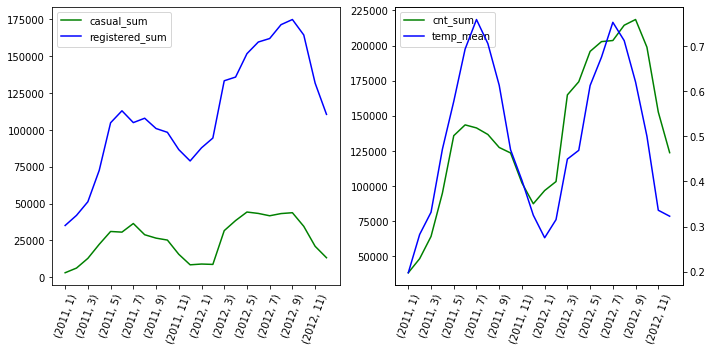

In [8]:
df_d_group = df_d.groupby([df_d.dteday.dt.year, df_d.dteday.dt.month])
colors = ['g', 'b', 'o']


feature_agg_combinations = [
    {'casual':np.sum, 'registered':np.sum},
    {'cnt':np.sum, 'temp':np.mean}
]


x = np.arange(0, len(df_d_group))
xtick_filt = x % 2 == 0

num_comb = len(feature_agg_combinations)
fig, axes = plt.subplots(figsize=(5 * num_comb, 5), ncols=num_comb)

for counter_ax, (ax, aggs) in enumerate(zip(axes, feature_agg_combinations)):
    
    df_d_plot = df_d_group.agg(aggs)
    lns = []

    for color, (col, agg) in zip(colors, aggs.items()):
        label = f'{col}_{agg.__name__}'
        
        if df_d_plot[col].mean() * 1000 < df_d_plot.values.mean():
            # use second y-axis
            
            ax1 = plt.twinx(ax)
            ln = ax1.plot(x, df_d_plot[col], label=label, color=color)
        else:
            ln = ax.plot(x, df_d_plot[col], label=label, color=color)

        lns.extend(ln)
    
    ax.set_xticks(x[xtick_filt])
    ax.set_xticklabels(df_d_plot.index[xtick_filt], rotation=70)
    
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels, loc=0)

plt.tight_layout()
plt.show()

### Show distribution of cnt per weathersit per season
Bike rentals are most popular in spring and summer with most bikes being rent on clear days.

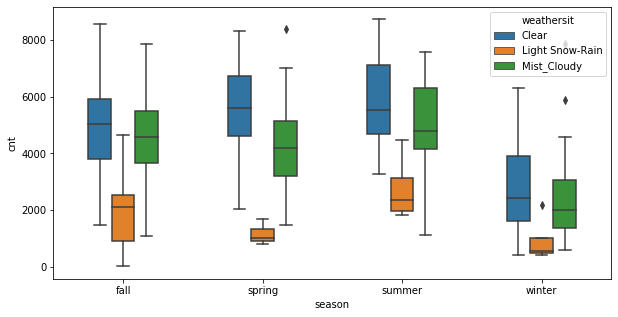

In [9]:
fig = plt.figure(figsize=[10, 5])
sns.boxplot(x=df_d.season, y=df_d.cnt, hue=df_d.weathersit, width=0.5)
plt.show()

## casual vs. registered
### per weekday
Most bikes are rent by registered user, who like to ride the bike on weekdays (assuming weekday 0 equals sunday). Casual riders on the opposite mostly rent a bike on the weekends. Possibly registered users use the bikes to commute to work, whereas casual users do it for pleasure.

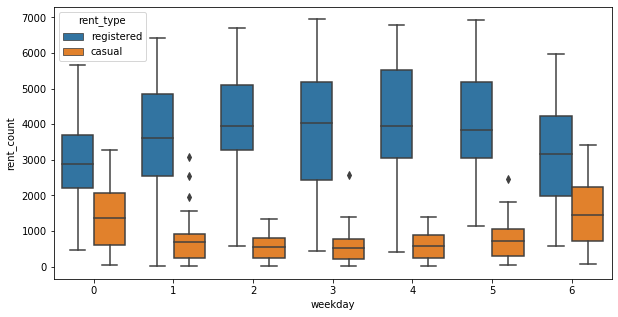

In [10]:
tmp = df_d.copy()
value_vars = ['registered', 'casual']
id_vars = [c for c in df_d.columns if c not in value_vars]
tmp = tmp.melt(id_vars=id_vars, value_vars=value_vars, var_name='rent_type', value_name='rent_count')

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=tmp.weekday, hue=tmp.rent_type, y=tmp.rent_count)

plt.show()

In [11]:
decimals = 1
col_ratio = 'ratio_cas_vs_reg'

tmp2 = df_d.loc[:, ['temp', 'hum', 'casual', 'registered', 'workingday']]


tmp2.temp = np.round(tmp2.temp, decimals=decimals)

tmp2[col_ratio] = np.round(tmp2.casual / tmp2.registered, 2)

tmp2 = tmp2.groupby(['temp', 'workingday'])[col_ratio].agg([np.mean, np.std])
tmp2 = tmp2.add_prefix(col_ratio + '_')
tmp2 = tmp2.reset_index()

tmp2.head()

,temp,workingday,ratio_cas_vs_reg_mean,ratio_cas_vs_reg_std
0,0.1,0,0.100000,0.057155
1,0.1,1,0.040000,0.014142
2,0.2,0,0.148889,0.066056
3,0.2,1,0.061622,0.044504
4,0.3,0,0.323269,0.178036


### Is the ratio of casual and regular users dependend on the temperature?
The ratio of casual users increases with higher temperature, especially on non-workingdays. However on non-workingdays the ratio decreases again above a temp=0.75. Possibly it is too hot for casual users, since they can apparently choose if they want to take the ride or not (mostly active on weekends).

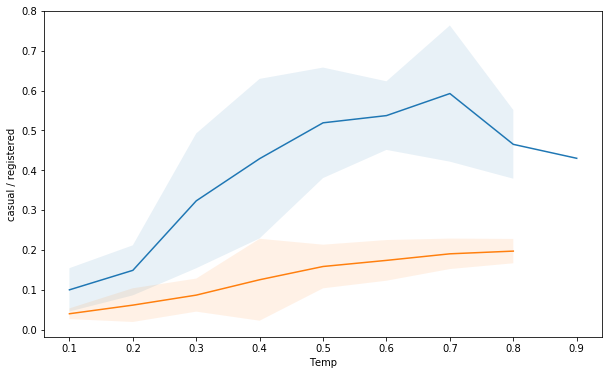

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ci = 0.95

for workingday in tmp2.workingday.unique():
    
    df_plot = tmp2.loc[tmp2.workingday==workingday, :]
    ax.plot(df_plot.temp, df_plot.ratio_cas_vs_reg_mean)
    
    
    y1 = df_plot.ratio_cas_vs_reg_mean - df_plot.ratio_cas_vs_reg_std * ci
    y2 = df_plot.ratio_cas_vs_reg_mean + df_plot.ratio_cas_vs_reg_std * ci
    ax.fill_between(df_plot.temp, y1=y1, y2=y2, alpha=.1)
    
ax.set_xlabel('Temp')
ax.set_ylabel('casual / registered')

plt.show()

## Load the hourly data

Preprocess the hourly data the same way as the daily data since the only difference is higher granularity due to the additional column 'hr'.

In [13]:
file_path = os.path.join(folder_path_data, 'hour.csv')
df_h = pd.read_csv(file_path, **csv_kwargs)
df_h = preprocess_data(df_h, mappings)
df_h = df_h.sort_values(['dteday', 'hr'])
df_h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  category      
 2   yr          17379 non-null  category      
 3   mnth        17379 non-null  category      
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  category      
 6   weekday     17379 non-null  category      
 7   workingday  17379 non-null  category      
 8   weathersit  17379 non-null  category      
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: category(7), dateti

### Visualize the rented bikes by casual/registered over hour
The registered users have peaks around 8 am and 17 pm which again indicates the start and end of business hours.

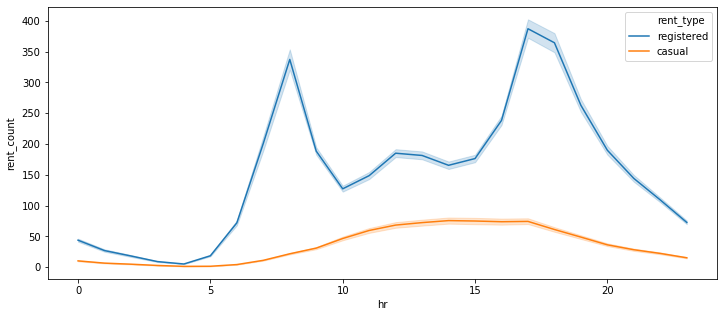

In [14]:
fig = plt.figure(figsize=(12, 5))

tmp = df_h.melt(value_vars=['registered', 'casual'], id_vars=['hr'], var_name='rent_type', value_name='rent_count')
sns.lineplot(data=tmp, x='hr', y='rent_count', hue='rent_type')

plt.show()

In [15]:
counts_per_day = df_h.reset_index().groupby('dteday')['instant'].count()
print('min count', counts_per_day.min())
print('max count', counts_per_day.max())

min count 1
max count 24


# Machine learning!
## Data transformation
### numeric features
We create rolling aggretations for the numeric features that are later fed to the model

In [16]:
rolls = pd.DataFrame()

# windows to use for looking back into the past in hour
windows = [8, 24]

aggs_all = [np.mean, np.min, np.max, np.std, np.sum]
aggs_no_sum = [np.mean, np.min, np.max, np.std]

# define which aggregations to use on which columns
aggs = {
    'casual':aggs_all,
    'registered':aggs_all,
    'hum':aggs_no_sum,
    'temp':aggs_no_sum,
    'windspeed':aggs_no_sum
}

for window in windows:
    tmp = df_h.rolling(window=window).agg(aggs)
    tmp.columns = ['_'.join(col) for col in tmp.columns]
    tmp = tmp.add_suffix(f'_{window}h')
    rolls = pd.concat([rolls, tmp], axis=1)

rolls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   casual_mean_8h       17372 non-null  float64
 1   casual_amin_8h       17372 non-null  float64
 2   casual_amax_8h       17372 non-null  float64
 3   casual_std_8h        17372 non-null  float64
 4   casual_sum_8h        17372 non-null  float64
 5   registered_mean_8h   17372 non-null  float64
 6   registered_amin_8h   17372 non-null  float64
 7   registered_amax_8h   17372 non-null  float64
 8   registered_std_8h    17372 non-null  float64
 9   registered_sum_8h    17372 non-null  float64
 10  hum_mean_8h          17372 non-null  float64
 11  hum_amin_8h          17372 non-null  float64
 12  hum_amax_8h          17372 non-null  float64
 13  hum_std_8h           17372 non-null  float64
 14  temp_mean_8h         17372 non-null  float64
 15  temp_amin_8h         17372 non-null 

In [17]:
# ml imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [18]:
fillna_val = 0

# concat the original hourly data with the rolling data
df_ml = pd.concat([df_h, rolls], axis=1, sort=False)

# drop irrelevant features 
# will predict [casual] and [registered] separately
df_ml = df_ml.drop(['dteday', 'cnt'], axis=1)

# one hot encode all non-numeric columns
df_ml = pd.get_dummies(df_ml, drop_first=True)

# fill empty columns
df_ml = df_ml.fillna(fillna_val)

# get the targets
y_reg = df_ml.registered.values
y_cas = df_ml.casual.values

# get the feature values without targets
X = df_ml.drop(['registered', 'casual'], axis=1)
# save columns of X for later
X_cols = X.columns.to_list()

# we split the available data in train/test and validation
# and make sure the last x percent of the data is validation
size_train_test = 0.7
val_split_idx = int(X.shape[0] * size_train_test)

# get bool array with the val indexes
val = np.arange(0, df_ml.shape[0]) > val_split_idx

# split up the data by non-val and val
X_val = X.loc[val, :].values
X = X.loc[~val, :].values

y_reg_val = y_reg[val]
y_reg = y_reg[~val]

y_cas_val = y_cas[val]
y_cas = y_cas[~val]


# show the date limits of the split
non_val_date_min = df_h.dteday[~val].dt.date.min()
non_val_date_max = df_h.dteday[~val].dt.date.max()
print(f'Train/Test set spans from {non_val_date_min} to {non_val_date_max}')

val_date_min = df_h.dteday[val].dt.date.min()
val_date_max = df_h.dteday[val].dt.date.max()
print(f'Validation set spans from {val_date_min} to {val_date_max}')

Train/Test set spans from 2011-01-01 to 2012-05-27
Validation set spans from 2012-05-27 to 2012-12-31


In [19]:
# TODO: Correlation analysis of the dataset
# TODO: Hyperparameter and preprocessing optimization on the train/test set

### predict the validation set using a bunch of different target periods

In [20]:
verbose = False
target_periods = np.arange(1, 15, 1)

models = {
    'lr':Pipeline([('scaler', MinMaxScaler()), ('lr', LinearRegression())]),
    'rf':RandomForestRegressor(n_estimators=10)
}

errs = np.zeros([len(target_periods), len(models)])

t0 = time.time()
for counter_tp, target_period in enumerate(target_periods):
    
    y_cnt = df_h.cnt.shift(periods=-target_period).fillna(fillna_val).values
    y_cnt_val = y_cnt[val]
    y_cnt = y_cnt[~val]
    
    
    for counter_model, (model_name, model) in enumerate(models.items()):
        
        model.fit(X, y_reg)
        y_reg_preds = model.predict(X_val)
        model.fit(X, y_cas)
        y_cas_preds = model.predict(X_val)

        y_cnt_preds = y_cas_preds + y_reg_preds

        err = mean_absolute_error(y_cnt_preds, y_cnt_val)
        errs[counter_tp, counter_model] = err
        
        if verbose:
            print(f'{model_name:15} {target_period:3} {err:.2f}')
        
print('Finished predicting validation set in ')

DONE


### Analyze the error over the various target periods 

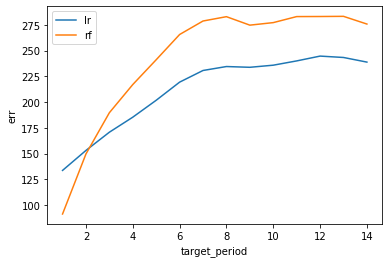

In [21]:
df_errs = pd.DataFrame(columns=models.keys(), data=errs)
df_errs['target_period'] = target_periods


ax = df_errs.plot(x='target_period')
ax.set_ylabel('err')

plt.show()

### feature importances of the last trained RandomForestRegressor

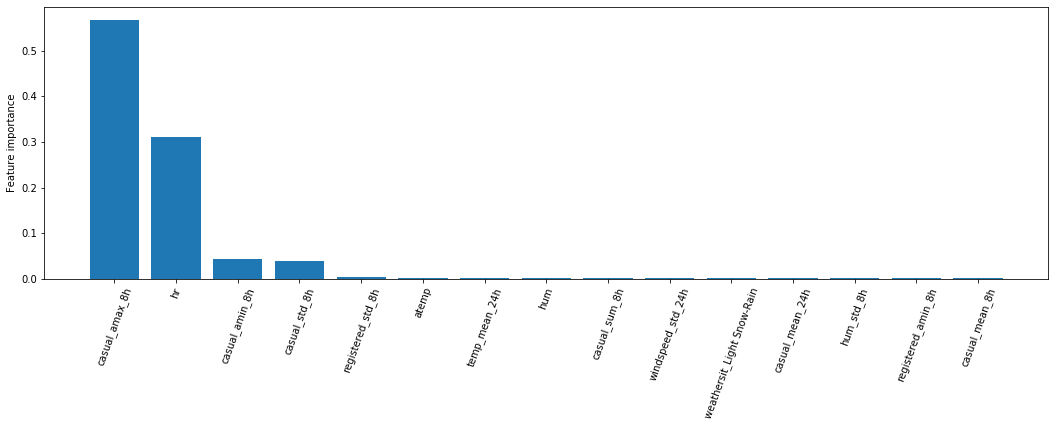

In [22]:
imps = models['rf'].feature_importances_

top_percent_feat = 0.2
thresh = sorted(imps, reverse=True)[int(len(imps) * top_percent_feat)]

imps = {col:imp for col, imp in zip(X_cols, imps) if imp > thresh}
imps = {k: v for k, v in sorted(imps.items(), key=lambda item: item[1], reverse=True)}


fig = plt.figure(figsize=(18, 5))
x_imps = np.arange(0, len(imps))
plt.bar(x=x_imps, height=list(imps.values()))

plt.xticks(x_imps, labels=imps.keys(), rotation=70)
plt.ylabel('Feature importance')

plt.show()